<a href="https://colab.research.google.com/github/yang-su2000/Authorship-Identification-with-NLP/blob/main/run_Stylo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/MyDrive/Colab Notebooks/Authorship Identification/")

import heapq
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

random_seed = 42
np.random.seed = 42

Mounted at /content/drive


### Load C50 Dataset (if already loaded)

- this (original dataset) is 50 train - 50 test split

In [ ]:
train_df = pd.read_csv('C50/train.csv')
test_df = pd.read_csv('C50/test.csv')

- this is 90 train - 10 test split

In [ ]:
test_frac = 0.1
train_df = pd.concat([train_df, test_df])
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index)

### Load "All the News" 1 Dataset

In [ ]:
test_frac = 0.15
train_df = pd.read_csv('All the News/articles1.csv')
train_df = train_df[(train_df.publication == 'Breitbart')]
top10_authors = train_df[['author','id']].groupby('author').count().sort_values(by='id', ascending=False).head(10).reset_index() # this == what the paper proposed
print('The authors are', top10_authors.author.values)
train_df = pd.merge(train_df, top10_authors[['author']], on='author', how='right')
train_df = train_df.groupby(by='author').sample(500, random_state=random_seed)
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index).reset_index()
test_df = test_df.reset_index()

The authors are ['Breitbart News' 'Pam Key' 'Charlie Spiering' 'Jerome Hudson'
 'John Hayward' 'Daniel Nussbaum' 'AWR Hawkins' 'Ian Hanchett'
 'Joel B. Pollak' 'Alex Swoyer']


### Preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(train_df['author'])
author_names = le.classes_
train_df['author_id'] = le.transform(train_df['author']).astype(int)
test_df['author_id'] = le.transform(test_df['author']).astype(int)
y_train = train_df['author_id']
y_test = test_df['author_id']

In [ ]:
train_df.head()

,index,Unnamed: 0,id,title,publication,author,date,year,month,url,content,author_id
0,6397,20138,38884,Carly Fiorina: 9th Circuit Decision Makes Defe...,Breitbart,AWR Hawkins,2016-06-11,2016.0,6.0,NaN,Carly Fiorina released a statement via email i...,0
1,6347,18597,37338,Former Assemblyman: Newsom’s Gun Control Push ...,Breitbart,AWR Hawkins,2016-04-30,2016.0,4.0,NaN,Former Assemblyman and current congressional c...,0
2,6111,9837,28573,Pre-Schooler Suspended for Bringing Empty .22 ...,Breitbart,AWR Hawkins,2017-03-23,2017.0,3.0,NaN,On Tuesday Hunter Jackson was suspended for...,0
3,6255,15584,34320,Donald Trump: I Won’t Let Politicians Disarm t...,Breitbart,AWR Hawkins,2016-02-05,2016.0,2.0,NaN,Republican presidential hopeful Donald Trump u...,0
4,6510,23613,42364,NRA Louisville Convention Garnered ’$53 Millio...,Breitbart,AWR Hawkins,2016-05-25,2016.0,5.0,NaN,"The NRA’s Annual Meetings and Exhibits, held i...",0


In [ ]:
# valid_frac = 0.1 / (1 - test_frac)
# valid_df = train_df.sample(frac=valid_frac, random_state=random_seed)
# train_df = train_df.drop(valid_df.index)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, stop_words='english')
X_train = vectorizer.fit_transform(train_df['content'])
X_test = vectorizer.transform(test_df['content'])
feat_names = vectorizer.get_feature_names_out()
feat_idf = vectorizer.idf_
X_train.shape, X_test.shape, X_train.nnz, X_test.nnz, y_train.shape, y_test.shape

((4250, 671707), (750, 671707), 1587148, 186894, (4250,), (750,))

In [ ]:
tfidf_df = pd.DataFrame(np.concatenate([feat_names[:,None], feat_idf[:,None]], axis=1), 
                        columns=['feat_name', 'feat_idf']).sort_values(by='feat_idf')
tfidf_df.tail(10)

,feat_name,feat_idf
248698,calls boycotts,8.661762
248699,calls brilliant,8.661762
248700,calls bringing,8.661762
248701,calls buyer,8.661762
248702,calls caliphate,8.661762
248703,calls carpet,8.661762
248704,calls clamp,8.661762
248705,calls clarity,8.661762
248707,calls companies,8.661762
671706,김태미 etammykim,8.661762


### Remove Top-k TF-IDF Words from EACH document

In [ ]:
def remove_topk_each(mat, k):
  doc_num = mat.shape[0]
  for i in range(doc_num):
    rowk = min(k, mat.getrow(i).nnz - 1)
    mask = mat.getrow(i).data.argpartition(-rowk)[-rowk:]
    mat.data[mat.indptr[i]:mat.indptr[i+1]][mask] = 0

### Remove Top-k TF-IDF Words from ALL documents

In [ ]:
def remove_topk_all(mat, k):
  doc_num = mat.shape[0]
  k = min(k, mat.nnz - 1)
  mask = mat.data.argpartition(-k)[-k:]
  mat.data[mask] = 0

### Remove TF-IDF Experiment (Individual Check)

In [ ]:
topk_tfidf = int(X_train.nnz * 0.9)
remove_topk_all(X_train, topk_tfidf)
remove_topk_all(X_test, topk_tfidf)

### From 11/03 Discussion: Remove Top-k DF Words from documents

In [ ]:
def remove_topk_df(mat, k):
  doc_num = mat.shape[0]
  mask = feat_idf.argpartition(k)[:k]
  diag = sparse.eye(mat.shape[1]).tolil()
  for c in mask:
    diag[c, c] = 0
  return mat.dot(diag)

In [ ]:
topk_tfidf = int(len(feat_names) * 0.5)
X_train = remove_topk_df(X_train, topk_tfidf)
X_test = remove_topk_df(X_test, topk_tfidf)

### Get TF-IDF Feat Values

In [ ]:
def get_tfidf_feat(feat_df, feat_data, author_name, top_k=5, larger=True):
  idxs = train_df.index[train_df['author'] == author_name].tolist()
  feat_val = feat_data[idxs]
  word_val = feat_names
  n = feat_val.shape[0]
  word_array = []
  val_array = []
  for i in range(n):
    val_col = feat_val[i].toarray()[0]
    idxs = np.argsort(val_col)[-top_k:][::-1] if larger else np.argsort(val_col)[top_k:]
    words = word_val[idxs]
    vals = val_col[idxs]
    word_array.append(words)
    val_array.append(vals)
  word_array = np.array(word_array)
  val_array = np.array(val_array)
  sorted_idxs = np.argsort(-val_array.sum(axis=1))
  return word_array[sorted_idxs], val_array[sorted_idxs]

In [ ]:
word_tfidf, val_tfidf = get_tfidf_feat(train_df, X_train, author_name='AWR Hawkins', top_k=5)

### 1. Naive Bayes Classifier

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_nb = clf.predict(X_test)
feat_nb = np.exp(clf.feature_log_prob_)
feat_df_nb = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_nb.shape[0]):
  feat_df_nb[author_names[i]] = feat_nb[i,:]
feat_df_nb.head()

,word,AWR Hawkins,Alex Swoyer,Breitbart News,Charlie Spiering,Daniel Nussbaum,Ian Hanchett,Jerome Hudson,Joel B. Pollak,John Hayward,Pam Key
0,00,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
1,00 00,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
2,00 11,0.000001,0.000001,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
3,00 AM,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
4,00 AWR,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001


### 2. SGD Classifier

In [ ]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
clf.fit(X_train, y_train)
y_sgd = clf.predict(X_test)
feat_sgd = clf.coef_
feat_df_sgd = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_sgd.shape[0]):
  feat_df_sgd[author_names[i]] = feat_sgd[i,:]
feat_df_sgd.head()

,word,AWR Hawkins,Alex Swoyer,Breitbart News,Charlie Spiering,Daniel Nussbaum,Ian Hanchett,Jerome Hudson,Joel B. Pollak,John Hayward,Pam Key
0,00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,00 00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,00 11,-0.130443,-0.141418,1.153049,-0.153165,-0.123409,-0.155786,-0.142418,-0.164203,-0.140879,-0.158586
3,00 AM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,00 AWR,0.723473,-0.088600,-0.095476,-0.090711,-0.075587,-0.105154,-0.098082,-0.072553,-0.080247,-0.084037


### Evaluate

In [ ]:
def eval_all(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1_macro = f1_score(y_test, y_pred, average='macro')
  print('accuracy:', accuracy, '   precision:', precision, '   recall:', recall, '   f1_macro:', f1_macro)
  return accuracy, f1_macro

In [ ]:
print('Naive Bayes Result')
eval_all(y_test, y_nb)
print('SGD Classifier Result')
eval_all(y_test, y_sgd)

Naive Bayes Result
accuracy: 0.23733333333333334    precision: 0.6824737150555478    recall: 0.2736238744359625    f1_macro: 0.23759847400843803
SGD Classifier Result
accuracy: 0.5146666666666667    precision: 0.5375923989910494    recall: 0.5189226737559263    f1_macro: 0.5113683471135014


(0.5146666666666667, 0.5113683471135014)

### Grid Search in Removing Top-k TF-IDF Words vs. Performances

In [ ]:
def grid_search_removed_tfidf_percent(bins, bound_percent, method='all'):
  nb_accs = []
  nb_f1s = []
  lr_accs = []
  lr_f1s = []
  nb_clf = MultinomialNB()
  lr_clf = SGDClassifier(loss='log', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
  if method == 'all':
    remove_ls = range(int(X_train.nnz * bound_percent / bins), int(X_train.nnz * bound_percent), int(X_train.nnz * bound_percent / bins))
  elif method == 'each':
    remove_ls = range(int(X_train.nnz / X_train.shape[0] * bound_percent / bins), \
                      int(X_train.nnz / X_train.shape[0] * bound_percent), int(X_train.nnz / X_train.shape[0] * bound_percent / bins))
  elif method == 'df':
    remove_ls = range(int(len(feat_names) * bound_percent / bins), int(len(feat_names) * bound_percent), int(len(feat_names) * bound_percent / bins))
  # grid search
  for topk_tfidf in remove_ls:
    X_train2 = X_train.copy()
    X_test2 = X_test.copy()
    if method == 'all':
      remove_topk_all(X_train2, topk_tfidf)
      remove_topk_all(X_test2, topk_tfidf)
    elif method == 'each':
      remove_topk_each(X_train2, topk_tfidf)
      remove_topk_each(X_test2, topk_tfidf)
    elif method == 'df':
      X_train2 = remove_topk_df(X_train2, topk_tfidf)
      X_test2 = remove_topk_df(X_test2, topk_tfidf)
    nb_clf.fit(X_train2, y_train)
    lr_clf.fit(X_train2, y_train)
    y_nb = nb_clf.predict(X_test2)
    y_lr = lr_clf.predict(X_test2)
    print('for k =', topk_tfidf)
    nb_acc, nb_f1 = eval_all(y_test, y_nb)
    lr_acc, lr_f1 = eval_all(y_test, y_lr)
    nb_accs.append(nb_acc)
    nb_f1s.append(nb_f1)
    lr_accs.append(lr_acc)
    lr_f1s.append(lr_f1)
    metric_ls = [('nb', nb_accs, nb_f1s), ('lr', lr_accs, lr_f1s)]
    # plot
  category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.25, 0.75, len(metric_ls)))
  plt.figure(figsize=(20,10))
  for (metric_name, acc, f1), color in zip(metric_ls, category_colors):
    plt.plot(remove_ls, acc, color=color, linestyle='solid', label=metric_name + ' accuracy')
    plt.plot(remove_ls, f1, color=color, linestyle='dashed', label=metric_name + ' f1')
  plt.xlabel('top-k TFIDF removed on ' + method + ' documents')
  plt.ylabel('metric value')
  plt.legend()
  plt.show()
  return remove_ls, metric_ls

for k = 6717
accuracy: 0.696    precision: 0.7339405711691821    recall: 0.705870414739144    f1_macro: 0.6926549904939086
accuracy: 0.7133333333333334    precision: 0.7424017739031183    recall: 0.7124135295738687    f1_macro: 0.7137925004012275
for k = 13434
accuracy: 0.632    precision: 0.6848150545483902    recall: 0.6454278880436806    f1_macro: 0.6274911969512388
accuracy: 0.664    precision: 0.7185800156625175    recall: 0.6620332062448573    f1_macro: 0.671656873006852
for k = 20151
accuracy: 0.596    precision: 0.6783950406644196    recall: 0.6159588237085132    f1_macro: 0.5953578941213657
accuracy: 0.6213333333333333    precision: 0.7045208614828173    recall: 0.6179122896205343    f1_macro: 0.6341576937909299
for k = 26868
accuracy: 0.5466666666666666    precision: 0.6692338845704818    recall: 0.5708902133053615    f1_macro: 0.5475537294522497
accuracy: 0.5893333333333334    precision: 0.6919188312936154    recall: 0.5868924062927381    f1_macro: 0.6055118606844787
for k =

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 463473
accuracy: 0.15866666666666668    precision: 0.5517794644739615    recall: 0.1915174143464251    f1_macro: 0.1351592020702749
accuracy: 0.4573333333333333    precision: 0.47288753314910564    recall: 0.4545130597119457    f1_macro: 0.4502056041323444


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 470190
accuracy: 0.15466666666666667    precision: 0.5490072788947387    recall: 0.18735672568071488    f1_macro: 0.12845486103790585
accuracy: 0.44133333333333336    precision: 0.43564865557477395    recall: 0.44008695039628415    f1_macro: 0.42640382568704227


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 476907
accuracy: 0.156    precision: 0.5664076560143976    recall: 0.18986264645867368    f1_macro: 0.1266511168831974
accuracy: 0.43866666666666665    precision: 0.4330212873568047    recall: 0.4367487296629875    f1_macro: 0.4221143905646447


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 483624
accuracy: 0.15066666666666667    precision: 0.5414521369001695    recall: 0.1842436100902535    f1_macro: 0.11895922585051524
accuracy: 0.428    precision: 0.4303698674637584    recall: 0.42343000289714716    f1_macro: 0.41062232634954343


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 490341
accuracy: 0.14133333333333334    precision: 0.46849673136609377    recall: 0.1741560875185034    f1_macro: 0.10434166577001773
accuracy: 0.4026666666666667    precision: 0.4236047456375416    recall: 0.4014286102167247    f1_macro: 0.39503254054059866


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 497058
accuracy: 0.13866666666666666    precision: 0.5665508021390374    recall: 0.17045756692674013    f1_macro: 0.10363969534116788
accuracy: 0.38266666666666665    precision: 0.4195054912362772    recall: 0.38044138057462773    f1_macro: 0.375633497600699


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 503775
accuracy: 0.132    precision: 0.5574257007767646    recall: 0.16308280092307675    f1_macro: 0.0935072724778931
accuracy: 0.37866666666666665    precision: 0.4171003180026441    recall: 0.37396409244915785    f1_macro: 0.365539688433676


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 510492
accuracy: 0.12933333333333333    precision: 0.41784467060789743    recall: 0.16056323910774029    f1_macro: 0.0895128031643067
accuracy: 0.37066666666666664    precision: 0.4096322281776736    recall: 0.36518772373932207    f1_macro: 0.3607400324646115


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 517209
accuracy: 0.12666666666666668    precision: 0.43103964853452564    recall: 0.15751544414121985    f1_macro: 0.08704748178465269
accuracy: 0.3626666666666667    precision: 0.40878132071707335    recall: 0.3516408270684495    f1_macro: 0.34229014196046437


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 523926
accuracy: 0.124    precision: 0.44691321499013814    recall: 0.1542367556166297    f1_macro: 0.08514073354284066
accuracy: 0.3586666666666667    precision: 0.40640830036193193    recall: 0.347439094926798    f1_macro: 0.33874595690528586


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 530643
accuracy: 0.12133333333333333    precision: 0.4466987051128021    recall: 0.15095806709203952    f1_macro: 0.08322417414111076
accuracy: 0.3586666666666667    precision: 0.4062004690010137    recall: 0.3496282650288448    f1_macro: 0.34200214942763996


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 537360
accuracy: 0.11866666666666667    precision: 0.4496189742272455    recall: 0.1481411656835888    f1_macro: 0.07920364509010995
accuracy: 0.34933333333333333    precision: 0.3870569540148746    recall: 0.3409182603761387    f1_macro: 0.32596114592781467


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 544077
accuracy: 0.11466666666666667    precision: 0.44752406719939597    recall: 0.14322313289670358    f1_macro: 0.07526535152643221
accuracy: 0.36133333333333334    precision: 0.3922209489752924    recall: 0.3567647956253196    f1_macro: 0.34725953505727664


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 550794
accuracy: 0.11466666666666667    precision: 0.44752406719939597    recall: 0.14322313289670358    f1_macro: 0.07526535152643221
accuracy: 0.34933333333333333    precision: 0.381779861919128    recall: 0.342250593791407    f1_macro: 0.33158515634771396


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 557511
accuracy: 0.10933333333333334    precision: 0.4459792166266986    recall: 0.13722627177040544    f1_macro: 0.06851396622402403
accuracy: 0.352    precision: 0.39411152199255095    recall: 0.3451007888416559    f1_macro: 0.3383562197528505


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 564228
accuracy: 0.10933333333333334    precision: 0.4481896551724138    recall: 0.13745716532847516    f1_macro: 0.06767900556398725
accuracy: 0.33866666666666667    precision: 0.3946206327091799    recall: 0.33488342673125004    f1_macro: 0.3300827972958949


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 570945
accuracy: 0.11066666666666666    precision: 0.3546153578511534    recall: 0.13941219681757938    f1_macro: 0.06835776965800544
accuracy: 0.34    precision: 0.40022520343823886    recall: 0.3360526759557808    f1_macro: 0.33988893339586257


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 577662
accuracy: 0.104    precision: 0.2581575246132208    recall: 0.13197281962727905    f1_macro: 0.058887135330816166
accuracy: 0.33466666666666667    precision: 0.38729104166148914    recall: 0.3296922502694507    f1_macro: 0.3345312874064247


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 584379
accuracy: 0.1    precision: 0.15810055865921788    recall: 0.12753134040501446    f1_macro: 0.05366839878467785
accuracy: 0.28933333333333333    precision: 0.4040903672505678    recall: 0.2843541849048191    f1_macro: 0.2959249448233451


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 591096
accuracy: 0.09733333333333333    precision: 0.16454386914426605    recall: 0.1242526518804243    f1_macro: 0.05151941954758856
accuracy: 0.27466666666666667    precision: 0.41715291429871704    recall: 0.26810404022258644    f1_macro: 0.2811073790763145


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 597813
accuracy: 0.09466666666666666    precision: 0.16298898071625345    recall: 0.12097396335583413    f1_macro: 0.04767069790879315
accuracy: 0.32133333333333336    precision: 0.35121428193540405    recall: 0.3221839667393245    f1_macro: 0.32034129787388954


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 604530
accuracy: 0.088    precision: 0.15155821917808218    recall: 0.11269244837561931    f1_macro: 0.03836310897224603
accuracy: 0.2866666666666667    precision: 0.33777022965393316    recall: 0.2795048310885676    f1_macro: 0.28215749774772464


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 611247
accuracy: 0.08533333333333333    precision: 0.14623780039878267    recall: 0.10941375985102916    f1_macro: 0.03363993576382957
accuracy: 0.2693333333333333    precision: 0.3066659230386069    recall: 0.260768693188126    f1_macro: 0.2583928587517669


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 617964
accuracy: 0.084    precision: 0.1477445652173913    recall: 0.10777441558873409    f1_macro: 0.03133957396773589
accuracy: 0.25866666666666666    precision: 0.31866927514396737    recall: 0.24892587122351592    f1_macro: 0.2366696382464871


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 624681
accuracy: 0.08133333333333333    precision: 0.14521312584573748    recall: 0.10466448309114487    f1_macro: 0.02589784154346917
accuracy: 0.21733333333333332    precision: 0.30591904195914543    recall: 0.21721030291292473    f1_macro: 0.20637227562277882


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 631398
accuracy: 0.08133333333333333    precision: 0.1576923076923077    recall: 0.10466448309114487    f1_macro: 0.02612160939872656
accuracy: 0.24666666666666667    precision: 0.26976033654893616    recall: 0.24298806986380442    f1_macro: 0.2195954767039045


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 638115
accuracy: 0.08133333333333333    precision: 0.1576923076923077    recall: 0.10466448309114487    f1_macro: 0.02612160939872656
accuracy: 0.23066666666666666    precision: 0.2515138116247488    recall: 0.2253804398176995    f1_macro: 0.20356196577271407


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 644832
accuracy: 0.08133333333333333    precision: 0.08279569892473118    recall: 0.10491803278688525    f1_macro: 0.023694609629771723
accuracy: 0.22533333333333333    precision: 0.2930160562716837    recall: 0.22078478467903903    f1_macro: 0.21365875834494993


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 651549
accuracy: 0.08    precision: 0.0744414655942806    recall: 0.10327868852459017    f1_macro: 0.020677860696517412
accuracy: 0.17333333333333334    precision: 0.2954630754544606    recall: 0.19093070732897055    f1_macro: 0.17809360537190538


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 658266
accuracy: 0.07866666666666666    precision: 0.057754010695187166    recall: 0.10163934426229508    f1_macro: 0.01756666272795305
accuracy: 0.15066666666666667    precision: 0.27561818815362993    recall: 0.16829768648622284    f1_macro: 0.14524753220965606


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 664983
accuracy: 0.07733333333333334    precision: 0.007733333333333333    recall: 0.1    f1_macro: 0.014356435643564359
accuracy: 0.11333333333333333    precision: 0.23159611200531915    recall: 0.1329763684551174    f1_macro: 0.08786277185326441


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


for k = 671700
accuracy: 0.07733333333333334    precision: 0.007733333333333333    recall: 0.1    f1_macro: 0.014356435643564359
accuracy: 0.09066666666666667    precision: 0.009066666666666667    recall: 0.1    f1_macro: 0.01662591687041565


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


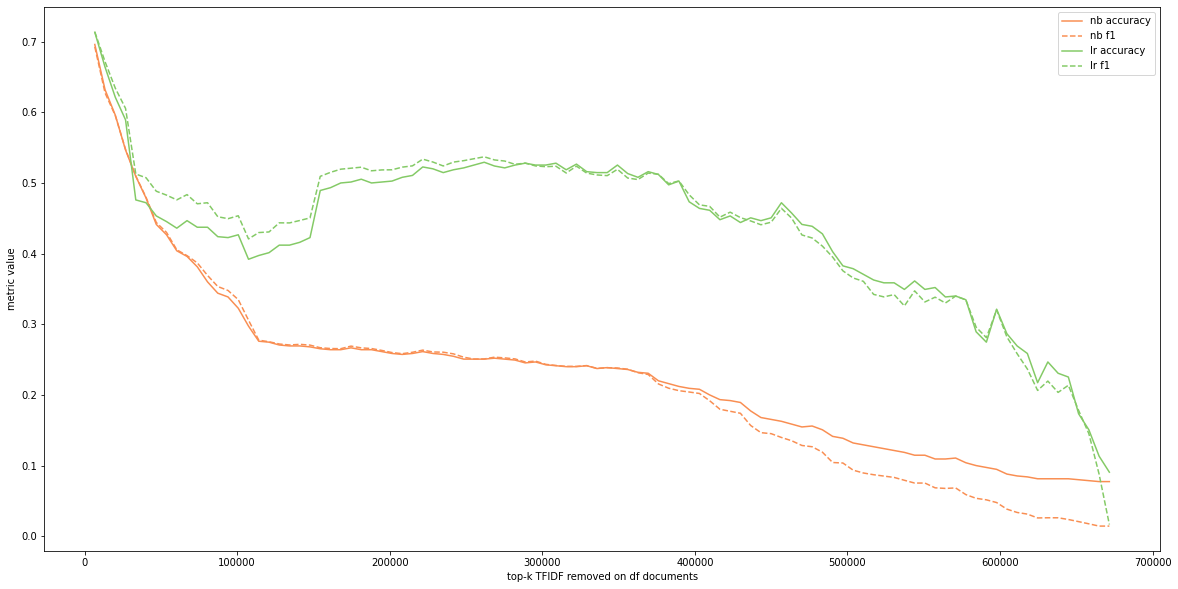

In [ ]:
bins = 100
bound_percent = 1
remove_ls, metric_ls = grid_search_removed_tfidf_percent(bins=bins, bound_percent=bound_percent, method='df')

### Feature Importance Extraction

In [ ]:
def get_feat_importance(feat_df, word_col, author_cols, top_k=5, larger=True):
  n = feat_df.shape[0]
  word_array = []
  val_array = []
  for author_col in author_cols:
    val_col = feat_df[author_col].values.take
    idxs = heapq.nlargest(top_k, range(n), val_col) if larger else heapq.nsmallest(top_k, range(n), val_col)
    words = feat_df[word_col][idxs]
    vals = feat_df[author_col][idxs]
    word_array.append(words)
    val_array.append(vals)
  word_array = np.array(word_array)
  val_array = np.array(val_array)
  sorted_idxs = np.argsort(-val_array.sum(axis=1))
  return word_array[sorted_idxs], val_array[sorted_idxs]

In [ ]:
word_array_nb, val_array_nb = get_feat_importance(feat_df_nb, 'word', author_names, top_k=5)
word_array_sgd, val_array_sgd = get_feat_importance(feat_df_sgd, 'word', author_names, top_k=5)

### Feature Importance Visualization

In [ ]:
def plot_feat_importance(word_array, val_array, author_cols, ycol_name):
  n, k = word_array.shape
  val_cum = val_array.cumsum(axis=1)
  category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.25, 0.75, val_array.shape[1]))
  fig, ax = plt.subplots(figsize=(k*6, n//2))
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)
  ax.set_xlim(0, np.sum(val_array, axis=1).max())
  for i, color in enumerate(category_colors):
    widthnames = word_array[:, i]
    widths = val_array[:, i]
    starts = val_cum[:, i] - widths
    ax.barh(author_cols, widths, left=starts, height=0.8, color=color)
    xcenters = starts + widths / 2
    for y, (x, name, val) in enumerate(zip(xcenters, widthnames, widths)):
      ax.text(x, y, name + ': ' + '{:.2f}'.format(val), ha='center', va='center', color='black')
  plt.ylabel(ycol_name)
  plt.title('top-' + str(k) + ' important word: importance values')
  plt.show()

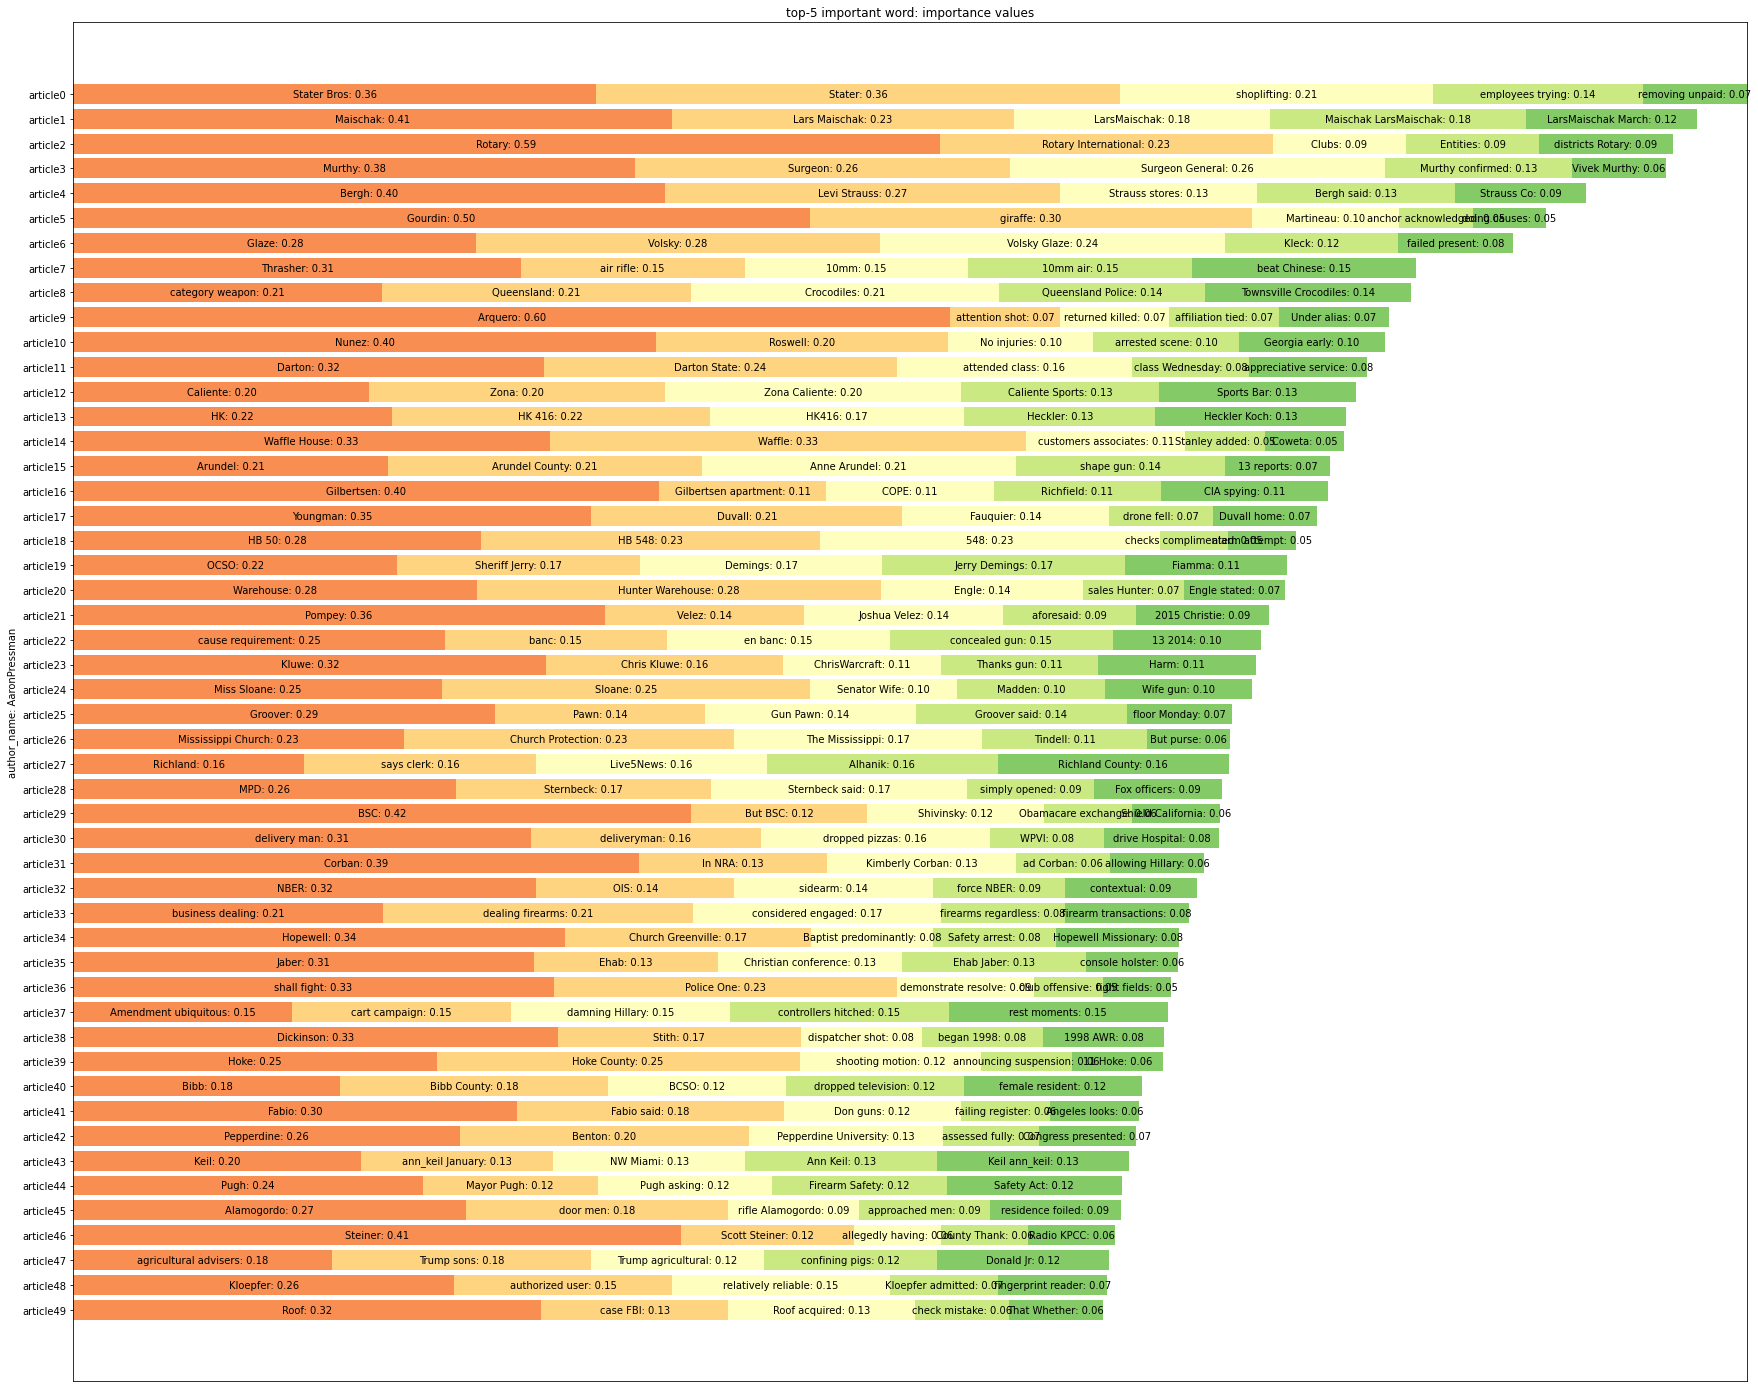

In [ ]:
plot_feat_importance(word_tfidf[:50], val_tfidf[:50], ['article' + str(i) for i in range(50)], 'author_name: AaronPressman')

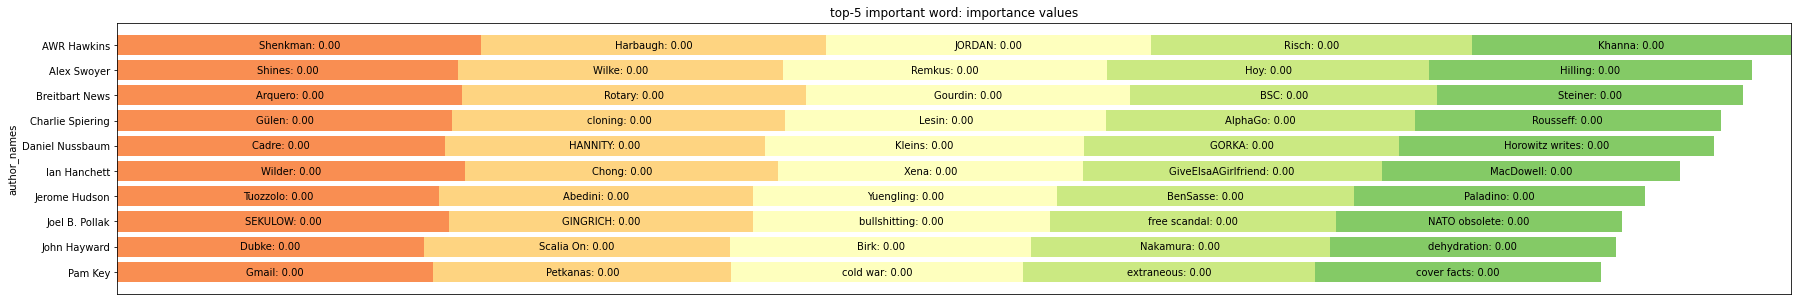

In [ ]:
plot_feat_importance(word_array_nb, val_array_nb, author_names, 'author_names')

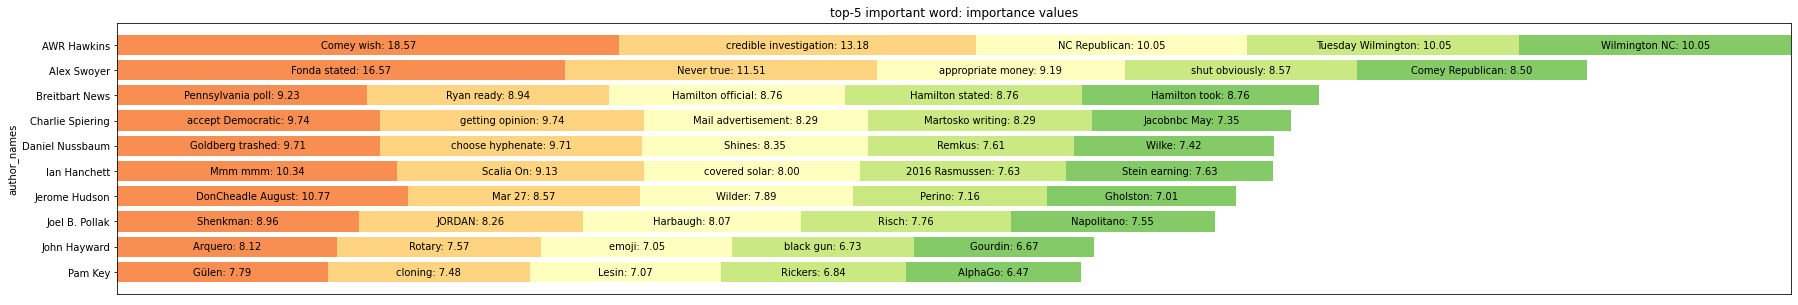

In [ ]:
plot_feat_importance(word_array_sgd, val_array_sgd, author_names, 'author_names')

### Test on the random seed

In [ ]:
acc = []
f1 = []
for i in range(1000):
  random_seed = i
  clf = SGDClassifier(loss='log', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
  clf.fit(X_train, y_train)
  y_sgd = clf.predict(X_test)
  accuracy, f1_macro = eval_all(y_test, y_sgd)
  acc.append(accuracy)
  f1.append(f1_macro)

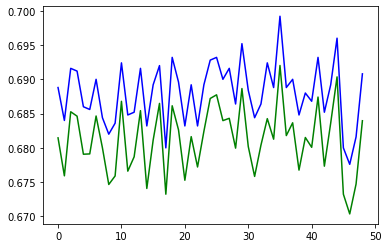

In [ ]:
plt.plot(range(49), acc, 'b')
plt.plot(range(49), f1, 'g')
plt.show()